# Linear regression with ``gluon``

Now that we've implemented a whole neural network from scratch, using nothing but ``mx.ndarray`` and ``mxnet.autograd``, let's see how we can make the same model while doing a lot less work. 

Again, let's import some packages, this time adding ``mxnet.gluon`` to the list of dependencies.

In [1]:
from __future__ import print_function
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
from mxnet import gluon

## Set the context

We'll also want to set a context to tell gluon where to do most of the computation.

In [2]:
ctx = mx.cpu()

## Build the dataset

Again we'll look at the problem of linear regression and stick with the same synthetic data. 

In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
    
X = nd.random_normal(shape=(num_examples, num_inputs))
noise = 0.01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise

## Load the data iterator

We'll stick with the ``DataLoader`` for handling out data batching.

In [4]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=True)

## Define the model

When we implemented things from scratch, we had to individually allocate parameters and then compose them together as a model. While it's good to know how to do things from scratch, with ``gluon``, we can just compose a network from predefined layers. For a linear model, the appropriate layer is called ``Dense``. It's called a *dense* layer because every node in the input is connected to every node in the subsequent layer. That description seems excessive because we only have one output here. But in most subsequent chapters we'll work with networks that have multiple outputs.

Unless we're planning to make some wild decisions (and at some point, we will!), the easiest way to throw together a neural network is to rely on the ``gluon.nn.Sequential``. Once instantiated, a Sequential just stores a chain of layers. Presented with data, the `Sequential` executes each layer in turn, using the output of one layer as the input for the next. We'll delve deeper into these details later when we actually have more than one layer to work with (we could have multiple parallel branches, long chains, etc.). For now let's just instantiate the ``Sequential``.

In [5]:
net = gluon.nn.Sequential()

Recall that in our linear regression example, the number of inputs is 2 and the number of outputs is 1. We can then add on a single ``Dense`` layer. The most direct way to do this is to specify the number of inputs and the number of outputs. 

In [6]:
with net.name_scope():
    net.add(gluon.nn.Dense(1, in_units=2))

This tells ``gluon`` all that it needs in order to allocate memory for the weights. The ``net.name_scope`` tells ``gluon`` that it should name all parameters in a consistent way within ``net``, such that we could reference individual weights explicitly at a later stage. Now all we need to do is initialize the weights, instantiate a loss and an optimizer, and we can start training.

## Shape inference

One slick feature that we can take advantage of in ``gluon`` is shape inference on parameters. 
Instead of explicitly declaring the number of inputs to a layer, 
we can simply state the number of outputs. 

In [7]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(1))

You might wonder, how can gluon allocate our parameters if it doesn't know what shape they should take? We'll elaborate on this and more of ``gluon``'s internal workings in [our chapter on plumbing](./P03.5-C01-plumbing.ipynb), but here's the short version: In fact, ``gluon`` doesn't allocate our parameters at that very moment. Instead it defers allocation to the first time we actually make a forward pass through the model with real data. Then, when ``gluon`` sees the shape of our data, it can infer the shapes of all of the parameters.

## Initialize parameters


This all we need to do to define our network. However, we're not ready to pass it data just yet. If you try calling ``net(nd.array([[0,1]]))``, you'll find the following hideous error message:

``RuntimeError: Parameter dense1_weight has not been initialized. 
Note that you should initialize parameters and create Trainer 
with Block.collect_params() instead of Block.params because the later does not include Parameters of nested child Blocks``.

That's because we haven't yet told ``gluon`` what the *initial values* for our parameters should be. Also note that we need not tell our network about the *input dimensionality* and it still works. This is because the dimensions are bound the first time ``net(x)`` is called. This is a common theme in MxNet - stuff is evaluated only when needed (called lazy evaluation), using all the information available at the time when the results is needed.

Before we can do anything with this model, we must initialize its parameters. *MXNet* provides a variety of common initializers in ``mxnet.init``. To keep things consistent with the model we built by hand, we'll choose to initialize each parameter by sampling from a standard normal distribution. Note that we pass the initializer a *context*. This is how we tell ``gluon`` model where to store our parameters. Once we start training deep nets, we'll generally want to keep parameters on one or more GPUs (and on more than one computer).

In [8]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=ctx)

## Deferred Initialization

Since ``gluon`` doesn't know the shape of our net's parameters, 
and we haven't even allocated memory for them yet, 
it might seem bizarre that we can initialize them. 
This is where ``gluon`` does a little more magic to make our lives easier.
When we call ``initialize``, ``gluon`` associates each parameter with an initializer.
However, the *actual initialization* is deferred until the shapes have been inferred. 



## Define loss

Instead of writing our own loss function we're just going to call down to ``gluon.loss.L2Loss`` 

In [9]:
square_loss = gluon.loss.L2Loss()

## Optimizer

Instead of writing stochastic gradient descent from scratch every time, we can instantiate a ``gluon.Trainer``, passing it a dictionary of parameters. Note that the ``sgd`` optimizer in ``gluon`` actually uses SGD with momentum and clipping (both can be switched off if needed), since these modifications make it converge rather much better. We will discuss this later when we go over a range of optimization algorithms in detail.

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## Execute training loop

You might have noticed that it was a bit more concise to express our model in ``gluon``. For example, we didn't have to individually allocate parameters, define our loss function, or implement stochastic gradient descent. The benefits of relying on ``gluon``'s abstractions will grow substantially once we start working with much more complex models. But once we have all the basic pieces in place, the training loop itself is quite similar to what we would do if implementing everything from scratch. 

To refresh your memory. For some number of ``epochs``, we'll make a complete pass over the dataset (``train_data``), grabbing one mini-batch of inputs and the corresponding ground-truth labels at a time. 

Then, for each batch, we'll go through the following ritual. So that this process becomes maximally ritualistic, we'll repeat it verbatim:
* Generate predictions (``yhat``) and the loss (``loss``) by executing a forward pass through the network.
* Calculate gradients by making a backwards pass through the network via ``loss.backward()``. 
* Update the model parameters by invoking our SGD optimizer (note that we need not tell ``trainer.step`` about which parameters but rather just the amount of data, since we already performed that in the initialization of ``trainer``).

In [11]:
epochs = 1
smoothing_constant = .01
moving_loss = 0
niter = 0
loss_seq = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        loss_seq.append(est_loss)
    
    print("Epoch %s. Moving avg of MSE: %s" % (e, est_loss))        

Epoch 0. Moving avg of MSE: 5.18669371906e-05


## Visualizing the learning curve
Now let's check how quickly SGD learns the linear regression model by plotting the learning curve.

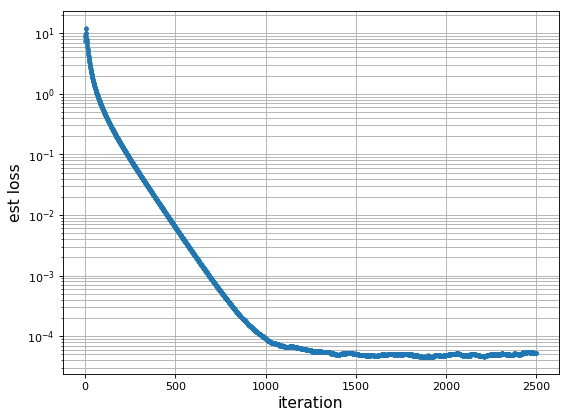

In [12]:
# plot the convergence of the estimated loss function 
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
plt.semilogy(range(niter),loss_seq, '.')

# adding some additional bells and whistles to the plot
plt.grid(True,which="both")
plt.xlabel('iteration',fontsize=14)
plt.ylabel('est loss',fontsize=14)

As we can see, the loss function converges linearly (exponentially) to the optimal solution.

## Getting the learned model parameters

As an additional sanity check, since we generated the data from a Gaussian linear regression model, we want to make sure that the learner managed to recover the model parameters, which were set to weight $2,-3.4$ with an offset of $4.2$.
    

In [13]:
params = net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())

The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
sequential1_dense0_weight 
[[ 2.00164366 -3.4004178 ]]
<NDArray 1x2 @cpu(0)>
sequential1_dense0_bias 
[ 4.19905281]
<NDArray 1 @cpu(0)>


## Conclusion 

As you can see, even for a simple example like linear regression, ``gluon`` can help you to write quick, clean, code. Next, we'll repeat this exercise for multi-layer perceptrons, extending these lessons to deep neural networks and (comparatively) real datasets. 

## Next
[The perceptron algorithm](../chapter02_supervised-learning/perceptron.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)